In [2]:
# from zipfile import ZipFile
# import sys
# import os
# file_path = '/content/deepreach-public_release.zip'

# with ZipFile(file_path, 'r') as zip:
#     zip.extractall()
#     print('Done')

# folder_path = '/content/deepreach-public_release'
# subdirectories = ['utils', 'dynamics', 'experiments']
# sys.path.append(folder_path)

# for subdir in subdirectories:
#     subdir_path = os.path.join(folder_path, subdir)
#     if subdir_path not in sys.path:
#         sys.path.append(subdir_path)
#     init_path = os.path.join(subdir_path, '__init__.py')
#     if not os.path.exists(init_path):
#         open(init_path, 'a').close()



In [3]:
from abc import ABC, abstractmethod
from utils import diff_operators
from dynamics import dynamics
import math
import torch

# DeepReach Tutorial
Download & Install Dependencies from https://github.com/smlbansal/deepreach/tree/public_release
##  Dynamics Implementation
In dynamics/dynamics.py, the main dynamics class is defined:
```
class Dynamics(ABC):
    def __init__(self,
    loss_type:str, set_mode:str,
    state_dim:int, input_dim:int,
    control_dim:int, disturbance_dim:int,
    state_mean:list, state_var:list,
    value_mean:float, value_var:float, value_normto:float,
    diff_model:bool):
        self.loss_type = loss_type
        self.set_mode = set_mode
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.control_dim = control_dim
        self.disturbance_dim = disturbance_dim
        self.state_mean = torch.tensor(state_mean)
        self.state_var = torch.tensor(state_var)
        self.value_mean = value_mean
        self.value_var = value_var
        self.value_normto = value_normto
        self.diff_model = diff_model
        assert self.loss_type in ['brt_hjivi', 'brat_hjivi'], f'loss type {self.loss_type} not recognized'
        #Specify if you're computing BRT or BRAT loss
        if self.loss_type == 'brat_hjivi':
            assert callable(self.reach_fn) and callable(self.avoid_fn)
        assert self.set_mode in ['reach', 'avoid'], f'set mode {self.set_mode} not recognized'
        for state_descriptor in [self.state_mean, self.state_var]:
            assert len(state_descriptor) == self.state_dim, 'state descriptor dimension does not equal state dimension, ' + str(len(state_descriptor)) + ' != ' + str(self.state_dim)

```
This class acts as the wrapper for all of the classes you define, including the state space, parameters, and mean/var needed for training.

There are also abstract methods that you can define on your own:
```
# ALL FOLLOWING METHODS USE REAL UNITS

    @abstractmethod
    def state_test_range(self):
        raise NotImplementedError

    @abstractmethod
    def equivalent_wrapped_state(self, state):
        raise NotImplementedError

    @abstractmethod
    def dsdt(self, state, control, disturbance):
        raise NotImplementedError

    @abstractmethod
    def boundary_fn(self, state):
        raise NotImplementedError

    @abstractmethod
    def sample_target_state(self, num_samples):
        raise NotImplementedError

    @abstractmethod
    def cost_fn(self, state_traj):
        raise NotImplementedError

    @abstractmethod
    def hamiltonian(self, state, dvds):
        raise NotImplementedError

    @abstractmethod
    def optimal_control(self, state, dvds):
        raise NotImplementedError

    @abstractmethod
    def optimal_disturbance(self, state, dvds):
        raise NotImplementedError

    @abstractmethod
    def plot_config(self):
        raise NotImplementedError
```
We will discuss how we can implement these in our running example!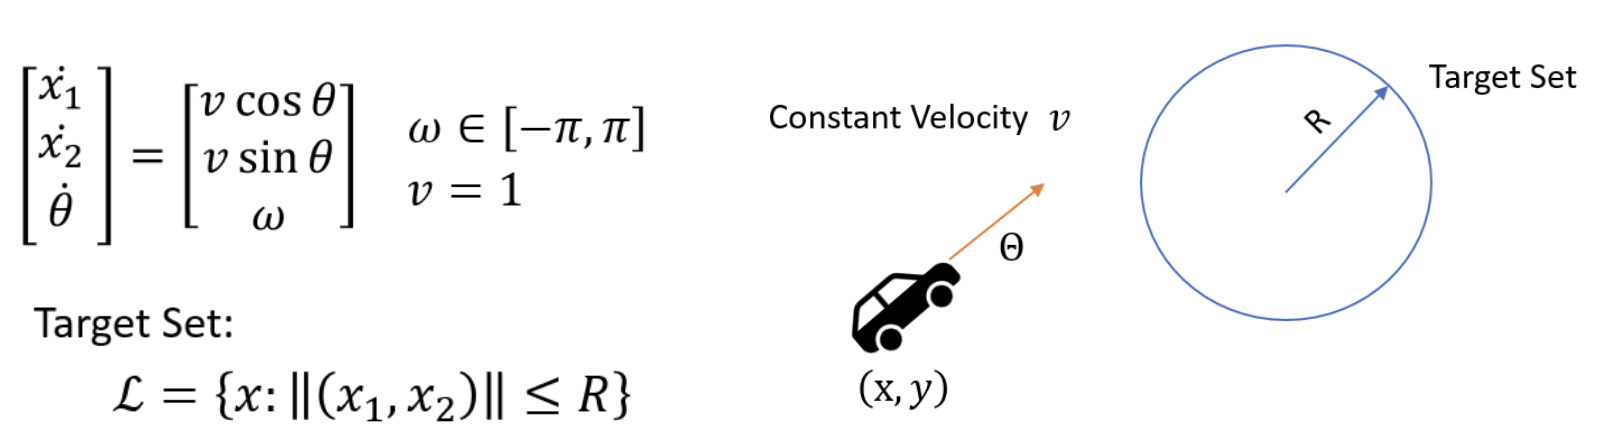


In [4]:
class Dynamics(ABC):
    def __init__(self,
    loss_type:str, set_mode:str,
    state_dim:int, input_dim:int,
    control_dim:int, disturbance_dim:int,
    state_mean:list, state_var:list,
    value_mean:float, value_var:float, value_normto:float,
    diff_model:bool):
        self.loss_type = loss_type
        self.set_mode = set_mode
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.control_dim = control_dim
        self.disturbance_dim = disturbance_dim
        self.state_mean = torch.tensor(state_mean)
        self.state_var = torch.tensor(state_var)
        self.value_mean = value_mean
        self.value_var = value_var
        self.value_normto = value_normto
        self.diff_model = diff_model
        assert self.loss_type in ['brt_hjivi', 'brat_hjivi'], f'loss type {self.loss_type} not recognized'
        if self.loss_type == 'brat_hjivi':
            assert callable(self.reach_fn) and callable(self.avoid_fn)
        assert self.set_mode in ['reach', 'avoid'], f'set mode {self.set_mode} not recognized'
        for state_descriptor in [self.state_mean, self.state_var]:
            assert len(state_descriptor) == self.state_dim, 'state descriptor dimension does not equal state dimension, ' + str(len(state_descriptor)) + ' != ' + str(self.state_dim)

    # ALL METHODS ARE BATCH COMPATIBLE

    # MODEL-UNIT CONVERSIONS (TODO: refactor into separate model-unit conversion class?)

    # convert model input to real coord
    def input_to_coord(self, input):
        coord = input.clone()
        coord[..., 1:] = (input[..., 1:] * self.state_var.to(device=input.device)) + self.state_mean.to(device=input.device)
        return coord

    # convert real coord to model input
    def coord_to_input(self, coord):
        input = coord.clone()
        input[..., 1:] = (coord[..., 1:] - self.state_mean.to(device=coord.device)) / self.state_var.to(device=coord.device)
        return input

    # convert model io to real value
    def io_to_value(self, input, output):
        if self.diff_model:
            return (output * self.value_var / self.value_normto) + self.boundary_fn(self.input_to_coord(input)[..., 1:])
        else:
            return (output * self.value_var / self.value_normto) + self.value_mean

    # convert model io to real dv
    def io_to_dv(self, input, output):
        dodi = diff_operators.jacobian(output.unsqueeze(dim=-1), input)[0].squeeze(dim=-2)

        if self.diff_model:
            dvdt = (self.value_var / self.value_normto) * dodi[..., 0]

            dvds_term1 = (self.value_var / self.value_normto / self.state_var.to(device=dodi.device)) * dodi[..., 1:]
            state = self.input_to_coord(input)[..., 1:]
            dvds_term2 = diff_operators.jacobian(self.boundary_fn(state).unsqueeze(dim=-1), state)[0].squeeze(dim=-2)
            dvds = dvds_term1 + dvds_term2

        else:
            dvdt = (self.value_var / self.value_normto) * dodi[..., 0]
            dvds = (self.value_var / self.value_normto / self.state_var.to(device=dodi.device)) * dodi[..., 1:]

        return torch.cat((dvdt.unsqueeze(dim=-1), dvds), dim=-1)

    # ALL FOLLOWING METHODS USE REAL UNITS

    @abstractmethod
    def state_test_range(self):
        raise NotImplementedError

    @abstractmethod
    def equivalent_wrapped_state(self, state):
        raise NotImplementedError

    @abstractmethod
    def dsdt(self, state, control, disturbance):
        raise NotImplementedError

    @abstractmethod
    def boundary_fn(self, state):
        raise NotImplementedError

    @abstractmethod
    def sample_target_state(self, num_samples):
        raise NotImplementedError

    @abstractmethod
    def cost_fn(self, state_traj):
        raise NotImplementedError

    @abstractmethod
    def hamiltonian(self, state, dvds):
        raise NotImplementedError

    @abstractmethod
    def optimal_control(self, state, dvds):
        raise NotImplementedError

    @abstractmethod
    def optimal_disturbance(self, state, dvds):
        raise NotImplementedError

    @abstractmethod
    def plot_config(self):
        raise NotImplementedError

## Running Example: Dubin's Car
Let us consider a 3D Dubin's Car with constant velocity and omega as the control input (shown above).

First we have to define the Dubin's Car class:
```
class Dubins3D(Dynamics):
    ## Here we initialize the Dubin's Car class (reach) with problem parameters (omega_max, velocity, goalR)
    def __init__(self, goalR:float, velocity:float, omega_max:float, angle_alpha_factor:float, set_mode:str, freeze_model: bool):
        self.goalR = goalR
        self.velocity = velocity
        self.omega_max = omega_max
        self.angle_alpha_factor = angle_alpha_factor
        self.freeze_model = freeze_model
        #in super().init we haave to define the loss type, mean/variance for states and value, as well as # of dimensions
        #input dimensions is state_dim+1 because you have to consider time as well
        super().__init__(
            loss_type='brt_hjivi', set_mode=set_mode,
            state_dim=3, input_dim=4, control_dim=1, disturbance_dim=0,
            state_mean=[0, 0, 0],
            state_var=[1, 1, self.angle_alpha_factor*math.pi],
            value_mean=0.25,
            value_var=0.5,
            value_normto=0.02,
            diff_model=True
        )
```
Define the parameters here such as state/value mean/var, problem parameters (omega, velocity goalR), as well as the dimensions

We can define our state space (similar to a grid in helperOC) like so:
```
#Define your state space (similar to defining a grid in HelperOC)
    def state_test_range(self):
        return [
            [-1, 1],
            [-1, 1],
            [-math.pi, math.pi]
        ]
```
In order to account for periodicity, wrap your periodic dims:
```
#Account for periodicity
    def equivalent_wrapped_state(self, state):
        wrapped_state = torch.clone(state)
        wrapped_state[..., 2] = (wrapped_state[..., 2] + math.pi) % (2*math.pi) - math.pi
        return wrapped_state
```
Now we want to define our dynamics:
```
# Dubins3D dynamics
    # \dot x    = v \cos \theta
    # \dot y    = v \sin \theta
    # \dot \theta = u
    def dsdt(self, state, control, disturbance):
        if self.freeze_model:
            raise NotImplementedError
        dsdt = torch.zeros_like(state)
        dsdt[..., 0] = self.velocity*torch.cos(state[..., 2])
        dsdt[..., 1] = self.velocity*torch.sin(state[..., 2])
        dsdt[..., 2] = control[..., 0]
        return dsdt
```
The cost function needs to be initialized as well:
```
#Define boundary function (norm of position states with radius)
    def boundary_fn(self, state):
        return torch.norm(state[..., :2], dim=-1) - self.goalR
```
Define the Hamiltonian and optimal control as we derived in the slides:
```
#Define Hamiltonian following the tutorial
    def hamiltonian(self, state, dvds):
        if self.freeze_model:
            raise NotImplementedError
        if self.set_mode == 'reach':
            return self.velocity*(torch.cos(state[..., 2]) * dvds[..., 0] + torch.sin(state[..., 2]) * dvds[..., 1]) - self.omega_max * torch.abs(dvds[..., 2])
        elif self.set_mode == 'avoid':
            return self.velocity*(torch.cos(state[..., 2]) * dvds[..., 0] + torch.sin(state[..., 2]) * dvds[..., 1]) + self.omega_max * torch.abs(dvds[..., 2])

    #Optimal control for problem
    def optimal_control(self, state, dvds):
        if self.set_mode == 'reach':
            return (-self.omega_max*torch.sign(dvds[..., 2]))[..., None]
        elif self.set_mode == 'avoid':
            return (self.omega_max*torch.sign(dvds[..., 2]))[..., None]

    #Optimal disturbance for problem
    def optimal_disturbance(self, state, dvds):
        return 0
```
Finally, set your plot configurations for checkpoints during training:


```
#Plot configurations
    def plot_config(self):
        return {
            'state_slices': [0, 0, 0],
            'state_labels': ['x', 'y', r'$\theta$'],
            'x_axis_idx': 0,
            'y_axis_idx': 1,
            'z_axis_idx': 2,
        }
```
Your final dynamics class should look something like this:









In [5]:
class Dubins3D(Dynamics):
    ## Here we initialize the Dubin's Car class (reach) with problem parameters (omega_max, velocity, goalR)
    def __init__(self, goalR:float, velocity:float, omega_max:float, angle_alpha_factor:float, set_mode:str, freeze_model: bool):
        self.goalR = goalR
        self.velocity = velocity
        self.omega_max = omega_max
        self.angle_alpha_factor = angle_alpha_factor
        self.freeze_model = freeze_model
        #in super().init we haave to define the loss type, mean/variance for states and value, as well as # of dimensions
        #input dimensions is state_dim+1 because you have to consider time as well
        super().__init__(
            loss_type='brt_hjivi', set_mode=set_mode,
            state_dim=3, input_dim=4, control_dim=1, disturbance_dim=0,
            state_mean=[0, 0, 0, 0],
            state_var=[1, 1, self.angle_alpha_factor*math.pi, 1],
            value_mean=0.25,
            value_var=0.5,
            value_normto=0.02,
            diff_model=True
        )
    #Define your state space (similar to defining a grid in HelperOC)
    def state_test_range(self):
        return [
            [-1, 1],
            [-1, 1],
            [-math.pi, math.pi]
        ]
    #Account for periodicity
    def equivalent_wrapped_state(self, state):
        wrapped_state = torch.clone(state)
        wrapped_state[..., 2] = (wrapped_state[..., 2] + math.pi) % (2*math.pi) - math.pi
        return wrapped_state

    # Dubins3D dynamics
    # \dot x    = v \cos \theta
    # \dot y    = v \sin \theta
    # \dot \theta = u
    def dsdt(self, state, control, disturbance):
        if self.freeze_model:
            raise NotImplementedError
        dsdt = torch.zeros_like(state)
        dsdt[..., 0] = self.velocity*torch.cos(state[..., 2])
        dsdt[..., 1] = self.velocity*torch.sin(state[..., 2])
        dsdt[..., 2] = control[..., 0]
        return dsdt

    #Define boundary function (norm of position states with radius)
    def boundary_fn(self, state):
        return torch.norm(state[..., :2], dim=-1) - self.goalR

    #Only implement for complex boundary_fn
    def sample_target_state(self, num_samples):
        raise NotImplementedError

    #Define Hamiltonian following the tutorial
    def hamiltonian(self, state, dvds):
        if self.freeze_model:
            raise NotImplementedError
        if self.set_mode == 'reach':
            return self.velocity*(torch.cos(state[..., 2]) * dvds[..., 0] + torch.sin(state[..., 2]) * dvds[..., 1]) - self.omega_max * torch.abs(dvds[..., 2])
        elif self.set_mode == 'avoid':
            return self.velocity*(torch.cos(state[..., 2]) * dvds[..., 0] + torch.sin(state[..., 2]) * dvds[..., 1]) + self.omega_max * torch.abs(dvds[..., 2])

    #Optimal control for problem
    def optimal_control(self, state, dvds):
        if self.set_mode == 'reach':
            return (-self.omega_max*torch.sign(dvds[..., 2]))[..., None]
        elif self.set_mode == 'avoid':
            return (self.omega_max*torch.sign(dvds[..., 2]))[..., None]

    #Optimal disturbance for problem
    def optimal_disturbance(self, state, dvds):
        return 0

    #Plot configurations
    def plot_config(self):
        return {
            'state_slices': [0, 0, 0],
            'state_labels': ['x', 'y', r'$\theta$'],
            'x_axis_idx': 0,
            'y_axis_idx': 1,
            'z_axis_idx': 2,
        }

## Training your Value Function
To kick off training, start with:
```
python run_experiment.py --mode train --experiment_class DeepReach --dynamics_class Dubins3D --experiment_name dubins3d_tutorial_run --minWith target --goalR 0.25 --velocity 1 --omega_max 3.14 --set_mode reach
```
The run_experiment wraps all of the experiments and flags together for modular use. When training, we always want to define the mode, exp class & name:
```
--mode train --experiment_class DeepReach --experiment_name dubins3d_tutorial_run
```
The minWith flag determines the type of computation you'd like to do. In our case, we want to find the BRT (minimize the value function w.r.t. value and boundary function). set_mode flag finds which Hamiltonian you'd like to use (i.e. control minimizes/maximizes):
```
--minWith target
```
Previously when we defined our Dubin's Car class, we also defined a set of parameters:
```
--goalR 0.25 --velocity 1 --omega_max 3.14 --angle_alpha_factor 1.2
```






In [6]:
!python /content/deepreach-public_release/run_experiment.py --mode train --experiment_class DeepReach --dynamics_class Dubins3D --experiment_name dubins3d_tutorial_run --minWith target --goalR 0.25 --velocity 1 --omega_max 3.14 --angle_alpha_factor 1.2 --set_mode reach

python: can't open file '/content/deepreach-public_release/run_experiment.py': [Errno 2] No such file or directory


## How does pretraining/training work?
During pretrain (--pretrain), DeepReach learns the value function at the terminal time ONLY (in utils/dataio.py):
```
if self.pretrain:
            # only sample in time around the initial condition
            times = torch.full((self.numpoints, 1), self.tMin)
```
Once pretraining is over (iterations are met), training starts here:
```
else:
            # slowly grow time values from start time
            times = self.tMin + torch.zeros(self.numpoints, 1).uniform_(0, (self.tMax-self.tMin) * (self.counter / self.counter_end))
            # make sure we always have training samples at the initial time
            times[-self.num_src_samples:, 0] = self.tMin
        model_coords = torch.cat((times, model_states), dim=1)
```
During the actual training, the epochs scale with the time horizon given (think of it as discretizing over time). Some samples are still allocated towards training the terminal time value function to enforce dirichlet loss.
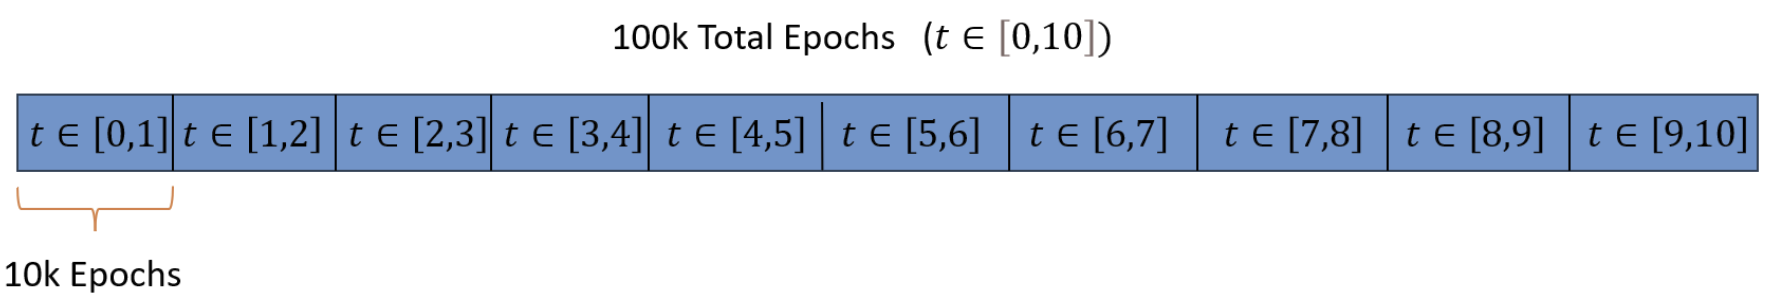





## Useful Flags For Training
```
--adj_rel_grads
```
This flag makes the training process less sensitive to the relative weights between PDE and dirichlet loss. If there’s a large variance in total loss, then consider using this flag (will make training slower, but never hurts to have it on)


```
--num_epochs x
```
If you find that your value function is not being trained (discretized) enough, consider increasing the number of epochs


```
--pretrain_iters
```
Setting this flag to 0 is useful when tuning lambda. You can also increase this to refine your dirichlet loss



```
--use_wandb
```
You can validate your training and visualize your value function through this flag







## Scaling Value
In utils/dataio.py, modify the following block by adding these print statements:

```
print('Min and max value before normalization are %0.4f and %0.4f' %(min(boundary_values), max(boundary_values)))
boundary_values = (boundary_values - self.value_mean)*self.value_normto/self.value_var
print('Min and max value after normalization are %0.4f and %0.4f' %(min(boundary_values), max(boundary_values)))
```
From here, you can obtain your value_mean and value_var that you can input when you first define your dynamics!

Do this here:


In [7]:
 def __getitem__(self, idx):
        # uniformly sample domain and include coordinates where source is non-zero
        model_states = torch.zeros(self.numpoints, self.dynamics.state_dim).uniform_(-1, 1)
        if self.num_target_samples > 0:
            target_state_samples = self.dynamics.sample_target_state(self.num_target_samples)
            model_states[-self.num_target_samples:] = self.dynamics.coord_to_input(torch.cat((torch.zeros(self.num_target_samples, 1), target_state_samples), dim=-1))[:, 1:self.dynamics.state_dim+1]

        if self.pretrain:
            # only sample in time around the initial condition
            times = torch.full((self.numpoints, 1), self.tMin)
        else:
            # slowly grow time values from start time
            times = self.tMin + torch.zeros(self.numpoints, 1).uniform_(0, (self.tMax-self.tMin) * (self.counter / self.counter_end))
            # make sure we always have training samples at the initial time
            times[-self.num_src_samples:, 0] = self.tMin
        model_coords = torch.cat((times, model_states), dim=1)
        if self.dynamics.input_dim > self.dynamics.state_dim + 1: # temporary workaround for having to deal with dynamics classes for parametrized models with extra inputs
            model_coords = torch.cat((model_coords, torch.zeros(self.numpoints, self.dynamics.input_dim - self.dynamics.state_dim - 1)), dim=1)

        #Initialize boundary function
        boundary_values = self.dynamics.boundary_fn(self.dynamics.input_to_coord(model_coords)[..., 1:])

        ## ADD PRINT STATEMENTS TO FIND VALUE_MEAN AND VALUE_VAR
        print('Min and max value before normalization are %0.4f and %0.4f' %(min(boundary_values), max(boundary_values)))
        boundary_values = (boundary_values - self.value_mean)*self.value_normto/self.value_var
        print('Min and max value after normalization are %0.4f and %0.4f' %(min(boundary_values), max(boundary_values)))

Now, run the experiment again to see the before/after normalization:
```
python run_experiment.py --mode train --experiment_class DeepReach --dynamics_class Dubins3D --experiment_name dubins3d_tutorial_run --minWith target --goalR 0.25 --velocity 1 --omega_max 3.14 --set_mode reach
```
Once the values are obtained, feel free to comment these out!


## Tuning Lambda
In utils/losses.py, modify the following block by adding these print statements:
```
#Lambda Tuning Objective: equalize dirichlet and PDE loss
print("dirichlet loss:", torch.abs(dirichlet).sum())
print("PDE loss:", torch.abs(diff_constraint_hom).sum())
```



In [8]:
def init_brt_hjivi_loss(dynamics, minWith, dirichlet_loss_divisor):
    def brt_hjivi_loss(state, value, dvdt, dvds, boundary_value, dirichlet_mask):
        if torch.all(dirichlet_mask):
            # pretraining/dirichlet loss
            diff_constraint_hom = torch.Tensor([0])
        else:
            ham = dynamics.hamiltonian(state, dvds)
            if minWith == 'zero':
                ham = torch.clamp(ham, max=0.0)
            diff_constraint_hom = dvdt - ham
            #PDE Loss consistent with formulation
            if minWith == 'target':
                diff_constraint_hom = torch.max(diff_constraint_hom, value - boundary_value)

        dirichlet = value[dirichlet_mask] - boundary_value[dirichlet_mask]

        #Lambda Tuning Objective: equalize dirichlet and PDE loss
        print("dirichlet loss:", torch.abs(dirichlet).sum())
        print("PDE loss:", torch.abs(diff_constraint_hom).sum())
        return {'dirichlet': torch.abs(dirichlet).sum() / dirichlet_loss_divisor,
                'diff_constraint_hom': torch.abs(diff_constraint_hom).sum()}

    return brt_hjivi_loss

We want to set the pretrain iters to 0 to see want the PDE vs. Dirichlet loss look like:
```
python run_experiment.py --pretrain_iters 0 --mode train --experiment_class DeepReach --dynamics_class Dubins3D --experiment_name dubins3d_tutorial_run --minWith target --goalR 0.25 --velocity 1 --omega_max 3.14 --set_mode reach
```
After obtaining the dirichlet divisor, comment this out as well!


## Parameterizing States
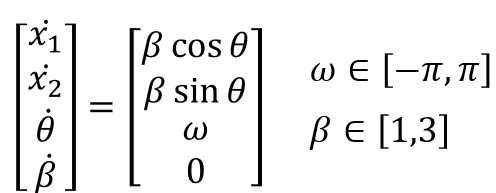

Parameterizing velocity means that we have to add an additional state to our system with zero dynamics. Lets implement that here:

In [9]:
class Dubins3D(Dynamics):
    def __init__(self, goalR:float, velocity:float, omega_max:float, angle_alpha_factor:float, set_mode:str, freeze_model: bool):
        self.goalR = goalR
        self.velocity = velocity
        self.omega_max = omega_max
        self.angle_alpha_factor = angle_alpha_factor
        self.freeze_model = freeze_model
        super().__init__(
            loss_type='brt_hjivi', set_mode=set_mode,
            state_dim=3, input_dim=4, control_dim=1, disturbance_dim=0,
            state_mean=[0, 0, 0, 2], # make sure to include mean and var for parameter states
            state_var=[1, 1, self.angle_alpha_factor*math.pi, 1],
            value_mean=0.25,
            value_var=0.5,
            value_normto=0.02,
            diff_model=True
        )

    def state_test_range(self):
        return [
            [-1, 1],
            [-1, 1],
            [-math.pi, math.pi],
            [1, 3] #Parameterize velocity from 1 m/s to 3 m/s
        ]

    def equivalent_wrapped_state(self, state):
        wrapped_state = torch.clone(state)
        wrapped_state[..., 2] = (wrapped_state[..., 2] + math.pi) % (2*math.pi) - math.pi
        return wrapped_state

    # Dubins3D dynamics
    # \dot x    = v \cos \theta
    # \dot y    = v \sin \theta
    # \dot \theta = u
    def dsdt(self, state, control, disturbance):
        if self.freeze_model:
            raise NotImplementedError
        dsdt = torch.zeros_like(state)
        #Replace velocity with the parameter state here!
        dsdt[..., 0] = state[...,4]*torch.cos(state[..., 2])
        dsdt[..., 1] = state[...,4]*torch.sin(state[..., 2])
        dsdt[..., 2] = control[..., 0]
        return dsdt

    def boundary_fn(self, state):
        return torch.norm(state[..., :2], dim=-1) - self.goalR

    def sample_target_state(self, num_samples):
        raise NotImplementedError

    def hamiltonian(self, state, dvds):
        if self.freeze_model:
            raise NotImplementedError
        if self.set_mode == 'reach':
            return self.velocity*(torch.cos(state[..., 2]) * dvds[..., 0] + torch.sin(state[..., 2]) * dvds[..., 1]) - self.omega_max * torch.abs(dvds[..., 2])
        elif self.set_mode == 'avoid':
            return self.velocity*(torch.cos(state[..., 2]) * dvds[..., 0] + torch.sin(state[..., 2]) * dvds[..., 1]) + self.omega_max * torch.abs(dvds[..., 2])

    def optimal_control(self, state, dvds):
        if self.set_mode == 'reach':
            return (-self.omega_max*torch.sign(dvds[..., 2]))[..., None]
        elif self.set_mode == 'avoid':
            return (self.omega_max*torch.sign(dvds[..., 2]))[..., None]

    def optimal_disturbance(self, state, dvds):
        return 0

    def plot_config(self):
        return {
            'state_slices': [0, 0, 0],
            'state_labels': ['x', 'y', r'$\theta$'],
            'x_axis_idx': 0,
            'y_axis_idx': 1,
            'z_axis_idx': 2,
        }

## Parameterizing Cost
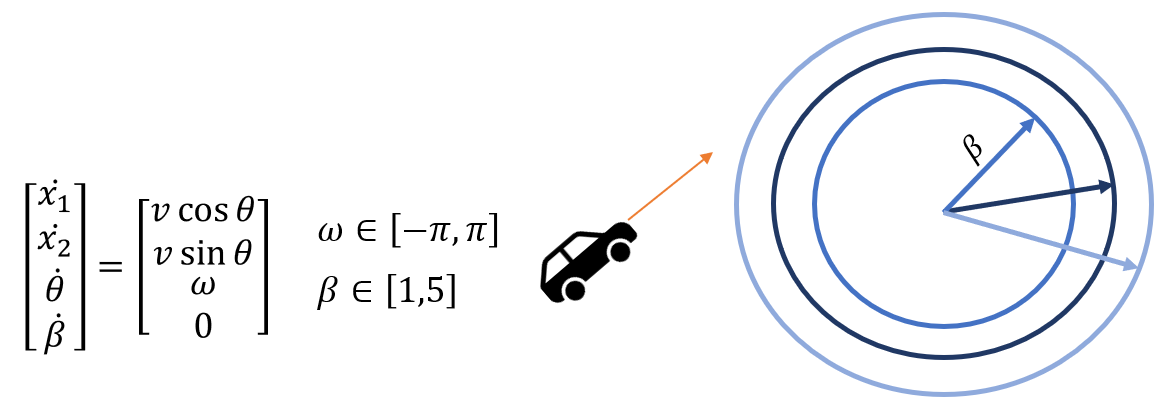

If we want to parameterize the goal radius in the cost function, we also have to define the parameter in the state space:

In [10]:
class Dubins3D(Dynamics):
    def __init__(self, goalR:float, velocity:float, omega_max:float, angle_alpha_factor:float, set_mode:str, freeze_model: bool):
        self.goalR = goalR
        self.velocity = velocity
        self.omega_max = omega_max
        self.angle_alpha_factor = angle_alpha_factor
        self.freeze_model = freeze_model
        super().__init__(
            loss_type='brt_hjivi', set_mode=set_mode,
            state_dim=3, input_dim=4, control_dim=1, disturbance_dim=0,
            state_mean=[0, 0, 0, 0], # make sure to include mean and var for parameters as well!
            state_var=[1, 1, self.angle_alpha_factor*math.pi, 1],
            value_mean=0.25,
            value_var=0.5,
            value_normto=0.02,
            diff_model=True
        )

    def state_test_range(self):
        return [
            [-1, 1],
            [-1, 1],
            [-math.pi, math.pi],
            [1, 5] #Parameterize target from r = 1 to 5
        ]

    def equivalent_wrapped_state(self, state):
        wrapped_state = torch.clone(state)
        wrapped_state[..., 2] = (wrapped_state[..., 2] + math.pi) % (2*math.pi) - math.pi
        return wrapped_state

    # Dubins3D dynamics
    # \dot x    = v \cos \theta
    # \dot y    = v \sin \theta
    # \dot \theta = u
    def dsdt(self, state, control, disturbance):
        if self.freeze_model:
            raise NotImplementedError
        dsdt = torch.zeros_like(state)
        dsdt[..., 0] = self.velocity*torch.cos(state[..., 2])
        dsdt[..., 1] = self.velocity*torch.sin(state[..., 2])
        dsdt[..., 2] = control[..., 0]
        return dsdt

    def boundary_fn(self, state):
        return torch.norm(state[..., :2], dim=-1) - state[...,4] #define the parameter state in the boundary_fn

    def sample_target_state(self, num_samples):
        raise NotImplementedError

    def hamiltonian(self, state, dvds):
        if self.freeze_model:
            raise NotImplementedError
        if self.set_mode == 'reach':
            return self.velocity*(torch.cos(state[..., 2]) * dvds[..., 0] + torch.sin(state[..., 2]) * dvds[..., 1]) - self.omega_max * torch.abs(dvds[..., 2])
        elif self.set_mode == 'avoid':
            return self.velocity*(torch.cos(state[..., 2]) * dvds[..., 0] + torch.sin(state[..., 2]) * dvds[..., 1]) + self.omega_max * torch.abs(dvds[..., 2])

    def optimal_control(self, state, dvds):
        if self.set_mode == 'reach':
            return (-self.omega_max*torch.sign(dvds[..., 2]))[..., None]
        elif self.set_mode == 'avoid':
            return (self.omega_max*torch.sign(dvds[..., 2]))[..., None]

    def optimal_disturbance(self, state, dvds):
        return 0

    def plot_config(self):
        return {
            'state_slices': [0, 0, 0],
            'state_labels': ['x', 'y', r'$\theta$'],
            'x_axis_idx': 0,
            'y_axis_idx': 1,
            'z_axis_idx': 2,
        }